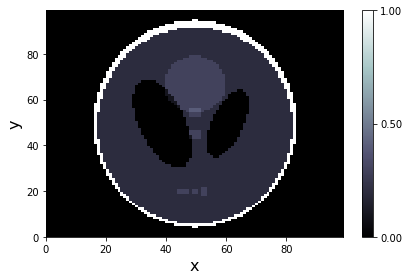

<Figure size 432x288 with 0 Axes>

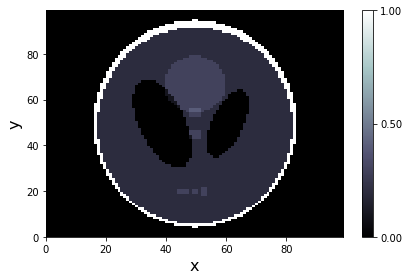

In [25]:
import odl
import numpy as np
import matplotlib.pyplot as plt

# Define a 3D space of (32,32,32)3 with 100 elements per dimension. Obtain a 3D Shepp-Logan phantom in that image space.
space=odl.uniform_discr([-16,-16,-16],[15,15,15],[100,100,100])
f=odl.phantom.transmission.shepp_logan(space,modified='True')
f[:,:,50].show()

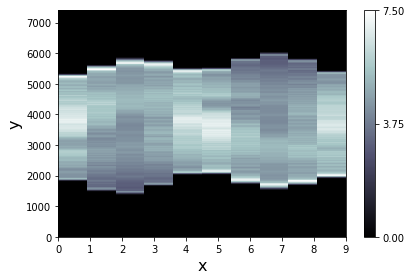

<Figure size 432x288 with 0 Axes>

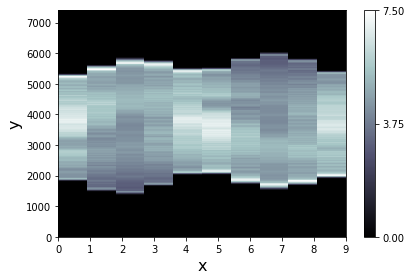

In [26]:
# Provide a Cone-Beam geometry with a certain source and detector radius, for 10 angles
# Create the sinogram for that geometry
src_radius=200
det_radius=10000
geometry=odl.tomo.geometry.conebeam.cone_beam_geometry(space, src_radius, det_radius, num_angles=10)
op=odl.tomo.operators.ray_trafo.RayTransform(space,geometry)
sinogram=op(f)
sinogram[:,:,50].show()

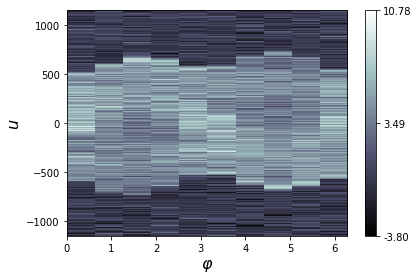

<Figure size 432x288 with 0 Axes>

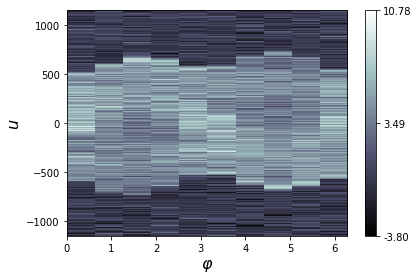

In [27]:
# Create a noisy sinogram, substract it to the original and get a noise estimate
noisy_sinogram=sinogram+odl.phantom.white_noise(op.range)
noisy_sinogram.show()

In [49]:
# Then the noise estimation can be computed as: 
delta=odl.discr.lp_discr.DiscreteLpElement.norm(sinogram-noisy_sinogram)

In [51]:
# Obtain transpose of A --> Backprojection
op_t=odl.tomo.operators.ray_trafo.RayBackProjection(space, geometry)
# Obtain estimate of largest singular value of A
sigma=odl.operator.Operator.norm(op,estimate=True)
# Start reconstruction from the vector zero
alfa=odl.discr.lp_discr.DiscreteLp.zero
# Reconstruction: use 2/sigma^2 as relaxation parameter?
a=odl.operator.operator.OperatorLeftScalarMult(op_t,-(2/sigma**2))
aux=odl.discr.lp_discr.DiscreteLp.zero
rec_error=np.zeros(200)
for i in range(200):
    aux=alfa
    b=odl.operator.operator.OperatorComp(op,alfa)
    alfa+=odl.operator.operator.OperatorComp(a,b-noisy_sinogram)
    # Check for Discrepancy Criterion: use safety factor=1?
    if odl.discr.lp_discr.DiscreteLpElement.norm(odl.operator.operator.OperatorComp(op,aux)-noisy_sinogram)<=delta and odl.discr.lp_discr.DiscreteLpElement.norm(b-noisy_sinogram)>=delta:
        print("Discrepancy Criterion met at iteration {}".format(i+1))
    # Compute reconstruction error with respect to the initial phantom
    rec_error[i]=odl.discr.lp_discr.DiscreteLpElement.norm(alfa-f)

alfa.show()
    
fig, ax = plt.subplots()
ax.plot(np.linspace(1,200,200), rec_error)

ax.set(xlabel='Number of iterations', ylabel='Reconstruction error',
       title='Reconstruction error vs Number of Iterations')
ax.grid()

AttributeError: 'function' object has no attribute 'range'